In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# We need to join the upper directory in order to access the local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import itertools
import json
import logging

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import scipy

from scipy.ndimage import uniform_filter1d
from scipy.io import loadmat, savemat

In [5]:
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 10

In [6]:
from pytdoa.mlat import exact, lls, nlls
from pytdoa.pytdoa import brutefoptim, nonlinoptim, linoptim
from pytdoa.util import generate_heatmap, generate_hyperbola
from pytdoa.geodesy.geodesy import SPEED_OF_LIGHT

In [8]:
from util import moving_average

In [9]:
# Reading the mat files
with open('comnets_data/gnbPositions.json') as gnb_file:
    data = json.load(gnb_file)

gNBs = np.array([data['gnb0'],data['gnb1'],data['gnb2'],data['gnb3']])

with open('comnets_data/uePositions.json') as ue_file:
    data = json.load(ue_file)

UEs = np.array([data['ue0'],data['ue1'],data['ue2'],data['ue3'],data['ue4'],data['ue5']])
UEs

array([[1.8 , 6.07],
       [1.  , 6.07],
       [1.8 , 9.14],
       [3.28, 2.97],
       [0.58, 2.03],
       [5.28, 7.68]])

## Playing a bit with each of the positions (there are 6 in total)

In [50]:
POSITION = 4
OVERSAMPLING = 16
OS_F = float(OVERSAMPLING)
FREQUENCY_MHZ = 100 # MHz
FREQUENCY = FREQUENCY_MHZ * 1e6

In [51]:
toa_measurements = pd.read_csv(f'comnets_data/oversampling/os{OVERSAMPLING}/exp{POSITION}_{FREQUENCY_MHZ}mhz.csv')
toa_measurements.drop(['Unnamed: 0',], axis=1, inplace=True)
toa_measurements.head(7)

,gNB0,P0,gNB1,P1,gNB2,P2,gNB3,P3
0,0.0,-inf,0.0,-inf,0.0,-inf,0.0,-inf
1,0.0,-inf,0.0,-inf,0.0,-inf,0.0,-inf
2,0.0,-inf,0.0,-inf,0.0,-inf,0.0,-inf
3,0.0,-inf,3.4,-75.8,0.0,-inf,0.0,-inf
4,0.0,-inf,0.0,-inf,0.1,-60.7,0.0,-inf
5,0.0,-inf,0.0,-inf,0.0,-60.8,0.0,-inf
6,0.0,-inf,0.0,-inf,0.9,-60.8,0.0,-inf


In [52]:
toa_filt = toa_measurements.loc[~((toa_measurements == float('-inf')).any(axis=1))]
toa_filt.reset_index(drop=True, inplace=True)

toa_filt

,gNB0,P0,gNB1,P1,gNB2,P2,gNB3,P3


## Offset exploration

Text(0, 0.5, 'Measured ToA (samples)')

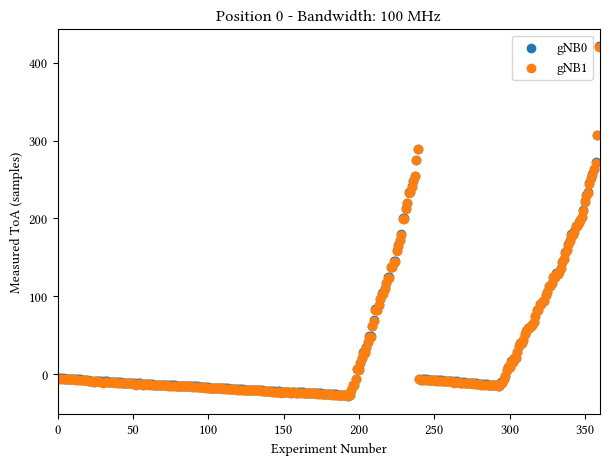

In [43]:
# Let's plot a bit the drift
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(x=np.arange(len(toa_filt)), y=toa_filt['gNB0'])
ax.scatter(x=np.arange(len(toa_filt)), y=toa_filt['gNB2'])

ax.legend(['gNB0','gNB1'])

ax.set_xlim([0,len(toa_filt)])

ax.set_title(f'Position {POSITION} - Bandwidth: {FREQUENCY_MHZ} MHz')
ax.set_xlabel('Experiment Number')
ax.set_ylabel('Measured ToA (samples)')

## Getting some experiments on

In [13]:
# Calculating the theoretical values
theoretical_toa = np.linalg.norm(UEs[POSITION] - gNBs, axis=1)
theoretical_tdoa_mat = theoretical_toa.reshape((-1,1)) - theoretical_toa
theoretical_tdoa = theoretical_tdoa_mat[np.triu_indices(4,k=1)]
theoretical_tdoa

array([ 0.47527784,  9.15963766,  7.43049195,  8.68435983,  6.95521411,
       -1.72914572])

In [33]:
EXPERIMENT = 1
FILTER_WINDOW = 10

#
gNB_toas_unfiltered = toa_filt[["gNB0","gNB1","gNB2","gNB3"]].to_numpy()
gNB_toas = gNB_toas_unfiltered
gNB_toas_selected = gNB_toas[EXPERIMENT,:]
gNB_tdoas_selected_mat = gNB_toas_selected.reshape(-1,1) - gNB_toas_selected
selected_tdoa = gNB_tdoas_selected_mat[np.triu_indices(4,k=1)]
selected_tdoa = selected_tdoa / FREQUENCY / OS_F * SPEED_OF_LIGHT
selected_tdoa

array([0.22484434, 0.22484434, 0.22484434, 0.22484434, 0.22484434,
       0.22484434, 0.22484434, 0.22484434, 0.14989623, 0.07494811])

In [21]:
# Plot the evolution
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 10

# Comparing regular vs moving average
# plt.scatter(x=np.arange(len(toa_filt)),y=toa_filt[])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1349445495.py, line 6)

In [17]:
linpos = linoptim(gNBs,selected_tdoa[0:4],input_type='xyz').squeeze()
print(f"Calculated Position - x: {linpos[0]:.4f} y: {linpos[1]:.4f}")
print(f"Real Position - x: {UEs[POSITION,0]:.4f} y: {UEs[POSITION,1]:.4f}")

Calculated Position - x: 0.2116 y: 3.5775
Real Position - x: 0.5800 y: 2.0300


In [20]:
combination_range = itertools.combinations(np.arange(len(gNBs)), 2)
combinations = np.fromiter(combination_range, dtype=np.dtype((int,2)))

position_nlls = nonlinoptim(gNBs, selected_tdoa, combinations, num_dim=2, p0=np.mean(gNBs,axis=0), input_type="xyz", method="BFGS")
position_nlls

array([[2.89233934, 4.07929226]])

In [19]:
position_brfc = brutefoptim(gNBs, selected_tdoa[0:4], combinations[0:4,:], xrange=10, yrange=10, step=1, epsilon=1e-5, num_dim=2, input_type="xyz")
position_brfc

array([-5.05376034e+08, -2.17606475e+08])

## Looping over all values

In [44]:
position_lls = 50*np.ones((len(toa_filt),2))
position_nls = 50*np.ones((len(toa_filt),2))

filter_w = 1
gNB_toas = moving_average(toa_filt[["gNB0","gNB1","gNB2","gNB3"]].to_numpy(),FILTER_WINDOW)

combination_range = itertools.combinations(np.arange(len(gNBs)), 2)
combinations = np.fromiter(combination_range, dtype=np.dtype((int,2)))
for i in range(len(gNB_toas)):
    gNB_toas_selected = gNB_toas[i,:]
    gNB_tdoas_selected_mat = gNB_toas_selected.reshape((-1,1)) - gNB_toas_selected
    selected_tdoa = gNB_tdoas_selected_mat[np.triu_indices(4,k=1)]
    selected_tdoa = selected_tdoa / FREQUENCY / OS_F * SPEED_OF_LIGHT

    position_lls[i,:] = linoptim(gNBs,selected_tdoa[0:4],input_type='xyz').squeeze()
    position_nls[i,:] = nonlinoptim(gNBs, selected_tdoa[0:4], combinations[0:4,:], num_dim=2, p0=np.mean(gNBs,axis=0), input_type="xyz", method="SLSQP").squeeze()


In [45]:
error_lls = np.linalg.norm((UEs[POSITION,:] - position_lls),axis=1)
error_nls = np.linalg.norm((UEs[POSITION,:] - position_nls),axis=1)

In [46]:
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 20

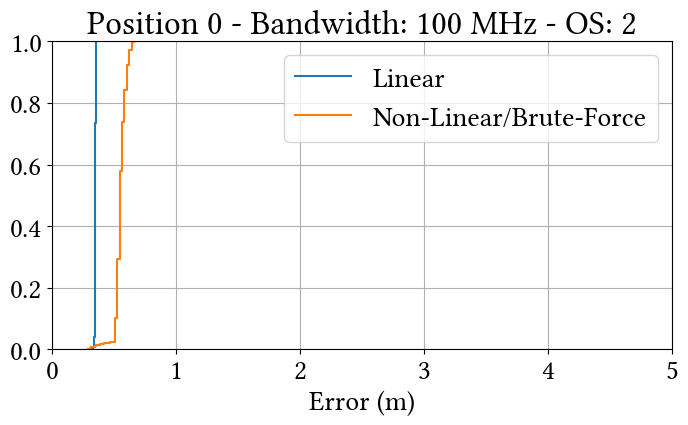

In [47]:
f, ax = plt.subplots(figsize=(8, 4))

ax.ecdf(error_lls)
ax.ecdf(error_nls)

ax.set_xlim([0,5])
ax.grid()

ax.set_title(f'Position {POSITION} - Bandwidth: {FREQUENCY_MHZ} MHz - OS: {OVERSAMPLING}')
ax.set_xlabel('Error (m)')
ax.legend(['Linear', 'Non-Linear/Brute-Force'])